In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-releases/game_data_all.csv
/kaggle/input/steam-releases/games-release-ALL.csv


# Import Required Libraries

In [68]:
import numpy as np
import pandas as pd
import datetime
from collections import Counter
import os
import pickle
import io
import time

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [28]:
df_ = pd.read_csv('../game_data_all.csv', index_col=0)
df = df_.copy()
df.head()

,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
0,Pizza Tower,/app/2231450/,2023-01-26,4529,19807,227,20034,96.39,Action (1),"Action (1), Indie (23)",Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.00,"3,101","3,606",4529,2023-03-25
1,Resident Evil 4,/app/2050650/,2023-03-24,168191,61752,1616,63368,95.75,Action (1),"Action (1), Adventure (25)",CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.00,"46,289","47,164",168191,2023-03-25
2,The Murder of Sonic the Hedgehog,/app/2324650/,2023-03-31,15543,12643,213,12856,95.54,Casual (4),"Casual (4), Free to Play (37), Indie (23), Simulation (28)",SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.00,618,776,15543,2023-03-31
3,Pineapple on pizza,/app/2263010/,2023-03-28,1415,11717,209,11926,95.39,Indie (23),"Casual (4), Free to Play (37), Indie (23)",Majorariatto,Majorariatto,Engine.Unity; SDK.cURL,2023-03-22,98.00,101,101,1415,2023-03-28
4,Hi-Fi RUSH,/app/1817230/,2023-01-25,6132,14152,324,14476,95.09,Action (1),Action (1),Bethesda Softworks,Tango Gameworks,Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; SDK.NVIDIA_APEX; SDK.NVIDIA_DLSS; SDK.NVIDIA_GeForce_Now; SDK.NVIDIA_Nsight_Aftermath; SDK.NVIDIA_PhysX; SDK.Vorbis; SDK.Wwise; SDK.XAudio2; SDK.iZotope,2023-04-11,97.00,630,664,6132,2023-01-29


In [29]:
def df_stats(data):
    bold("**" + " SHAPE ".center(50, "#") + "**")
    print("ROWS: {}".format(data.shape[0]))
    print("COLUMNS: {}".format(data.shape[1]))
    bold("**" + " TYPES ".center(50, "#") + "**")
    print(data.dtypes)
    bold("**" + " MISSING VALUES ".center(50, "#") + "**")
    print(data.isnull().sum())
    bold("**" + " DUPLICATED VALUES ".center(50, "#") + "**")
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    bold("**" + " MEMORY USAGE ".center(50, "#") + "**")
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))
    bold("**" + " DESCRIBE ".center(50, "#") + "**")
    print(data.describe().T)

In [30]:
df_stats(df)

****##################### SHAPE ######################****

ROWS: 67571
COLUMNS: 19


****##################### TYPES ######################****

game                      object
link                      object
release                   object
peak_players               int64
positive_reviews           int64
negative_reviews           int64
total_reviews              int64
rating                   float64
primary_genre             object
store_genres              object
publisher                 object
developer                 object
detected_technologies     object
store_asset_mod_time      object
review_percentage        float64
players_right_now         object
24_hour_peak              object
all_time_peak              int64
all_time_peak_date        object
dtype: object


****################# MISSING VALUES #################****

game                         0
link                         0
release                      0
peak_players                 0
positive_reviews             0
negative_reviews             0
total_reviews                0
rating                       0
primary_genre               10
store_genres                57
publisher                  461
developer                  128
detected_technologies     7306
store_asset_mod_time       296
review_percentage        19804
players_right_now            6
24_hour_peak                 6
all_time_peak                0
all_time_peak_date           6
dtype: int64


****############### DUPLICATED VALUES ################****

NUMBER OF DUPLICATED VALUES: 0


****################## MEMORY USAGE ##################****

Memory Usage: 10.3+ MB


****#################### DESCRIBE ####################****

                     count    mean      std   min   25%   50%    75%  \
peak_players      67571.00  952.87 19790.93  0.00  3.00  7.00  46.00   
positive_reviews  67571.00 1273.53 29551.63  0.00  5.00 19.00  99.00   
negative_reviews  67571.00  216.89  5434.96  0.00  1.00  6.00  29.00   
total_reviews     67571.00 1490.42 34009.23  1.00  7.00 26.00 132.00   
rating            67571.00   65.29    14.06 15.09 56.53 66.76  75.64   
review_percentage 47767.00   74.84    18.76  0.00 64.00 79.00  90.00   
all_time_peak     67571.00  962.99 20178.69  0.00  3.00  7.00  47.00   

                         max  
peak_players      3257248.00  
positive_reviews  6307931.00  
negative_reviews   927317.00  
total_reviews     7117776.00  
rating                 97.54  
review_percentage     100.00  
all_time_peak     3257248.00  


In [31]:
df.drop(['game', 'link'], axis=1, inplace=True)

In [32]:
df = df.dropna()

# Preprocess

In [33]:
df['players_right_now'] = df['players_right_now'].str.replace(',', '').astype(int)
df['24_hour_peak'] = df['24_hour_peak'].str.replace(',', '').astype(int)

In [34]:
def find_engine(text):
    if 'Engine.' in text:
        text = text.split(';')[0]
        text = text.replace('Engine.', '')
        return text
    else:
        return 'Unknown'

In [35]:
df['engine'] = df['detected_technologies'].apply(find_engine)

In [36]:
def find_sdk_count(text):
    return text.count('SDK.')

In [37]:
df['total_sdk'] = df['detected_technologies'].apply(find_sdk_count)

In [38]:
def find_release_year(text):
    return text.split('-')[0]

In [39]:
df['release_year'] = df['release'].apply(find_release_year).astype(int)

In [40]:
df['release_pd'] = pd.to_datetime(df['release'])

In [41]:
df['all_time_peak_date_pd'] = pd.to_datetime(df['all_time_peak_date'])

In [42]:
df['peak_after_days'] = (df['all_time_peak_date_pd'] - df['release_pd']).dt.days

In [43]:
top_100_publisher = list(df['publisher'].value_counts().head(100).keys())
top_100_developer = list(df['developer'].value_counts().head(100).keys())

In [44]:
def find_in_top_publishers(text):
    if text in top_100_publisher:
        return 1
    else:
        return 0

In [45]:
def find_in_top_developers(text):
    if text in top_100_developer:
        return 1
    else:
        return 0

In [46]:
df['is_in_top_100_publisher'] = df['publisher'].apply(find_in_top_publishers)

In [47]:
df['is_in_top_100_developer'] = df['developer'].apply(find_in_top_developers)

In [48]:
df['primary_genre'] = df['primary_genre'].astype(str)

In [49]:
def clear_parenthesis(text):
    text = text.split('(')[0].strip()
    return text

In [50]:
df['genre'] = df['primary_genre'].apply(clear_parenthesis)

In [51]:
df.drop(['release', 'release_pd', 'all_time_peak_date', 'all_time_peak_date_pd', 'detected_technologies',
         'store_genres', 'publisher', 'developer', 'store_asset_mod_time', 'primary_genre'], axis=1, inplace=True)

In [52]:
df.head()

,peak_players,positive_reviews,negative_reviews,total_reviews,rating,review_percentage,players_right_now,24_hour_peak,all_time_peak,engine,total_sdk,release_year,peak_after_days,is_in_top_100_publisher,is_in_top_100_developer,genre
0,4529,19807,227,20034,96.39,98.00,3101,3606,4529,GameMaker,1,2023,58,0,0,Action
1,168191,61752,1616,63368,95.75,97.00,46289,47164,168191,RE_Engine,1,2023,1,0,1,Action
2,15543,12643,213,12856,95.54,98.00,618,776,15543,Unity,2,2023,0,1,0,Casual
3,1415,11717,209,11926,95.39,98.00,101,101,1415,Unity,1,2023,0,0,0,Indie
4,6132,14152,324,14476,95.09,97.00,630,664,6132,Unreal,11,2023,4,1,0,Action


In [53]:
target = "rating"
numerical_variables = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != target]
categorical_variables = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == "O" and col != target]

In [54]:
bold("**NUMERICAL VARIABLES**")
print(numerical_variables)

****NUMERICAL VARIABLES****

['peak_players', 'positive_reviews', 'negative_reviews', 'total_reviews', 'review_percentage', 'players_right_now', '24_hour_peak', 'all_time_peak', 'total_sdk', 'release_year', 'peak_after_days', 'is_in_top_100_publisher', 'is_in_top_100_developer']


In [55]:
bold("**CATEGORICAL VARIABLES**")
print(categorical_variables)

****CATEGORICAL VARIABLES****

['engine', 'genre']


# Exploratory Data Analysis

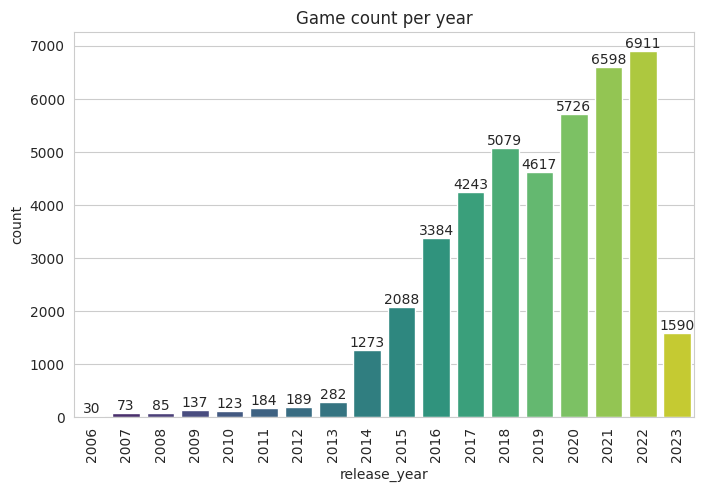

In [56]:
plt.figure(figsize=(8, 5))
plt.title('Game count per year')
ax = sns.countplot(data=df, x='release_year', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

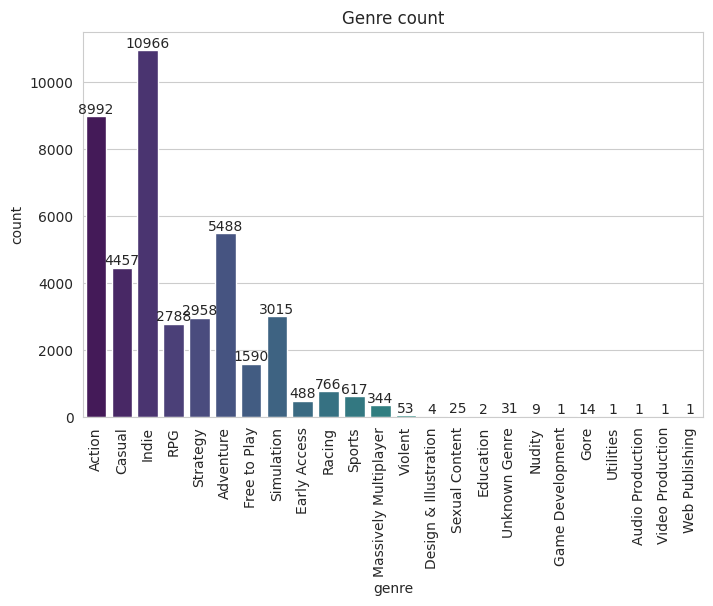

In [57]:
plt.figure(figsize=(8, 5))
plt.title('Genre count')
ax = sns.countplot(data=df, x='genre', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

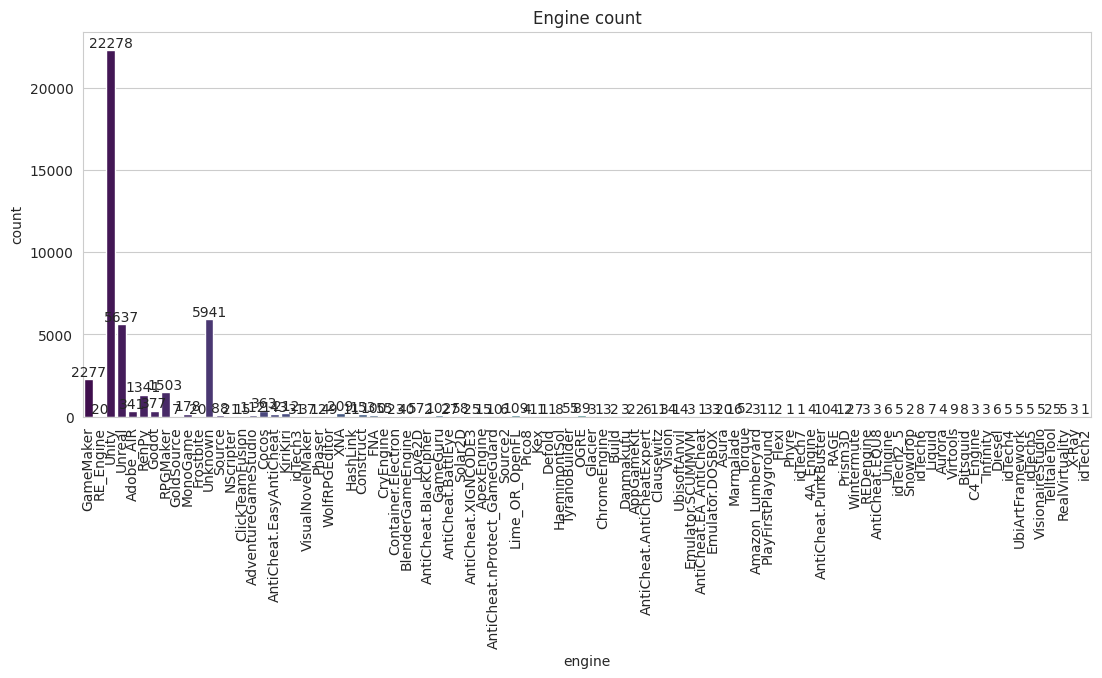

In [58]:
plt.figure(figsize=(13, 5))
plt.title('Engine count')
ax = sns.countplot(data=df, x='engine', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

In [59]:
def plot_num(df, columns):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2) + 1, 2, i + 1)
        sns.histplot(x=column, data=df, bins=30, kde=True)
        plt.axvline(df[column].mean(), color="r", linestyle="--", label="Mean")
        plt.axvline(df[column].median(), color="g", linestyle="-", label="Median")
        plt.grid()
        plt.title(f"{column} Distribution")
        plt.legend()
        plt.tight_layout()

    plt.show()

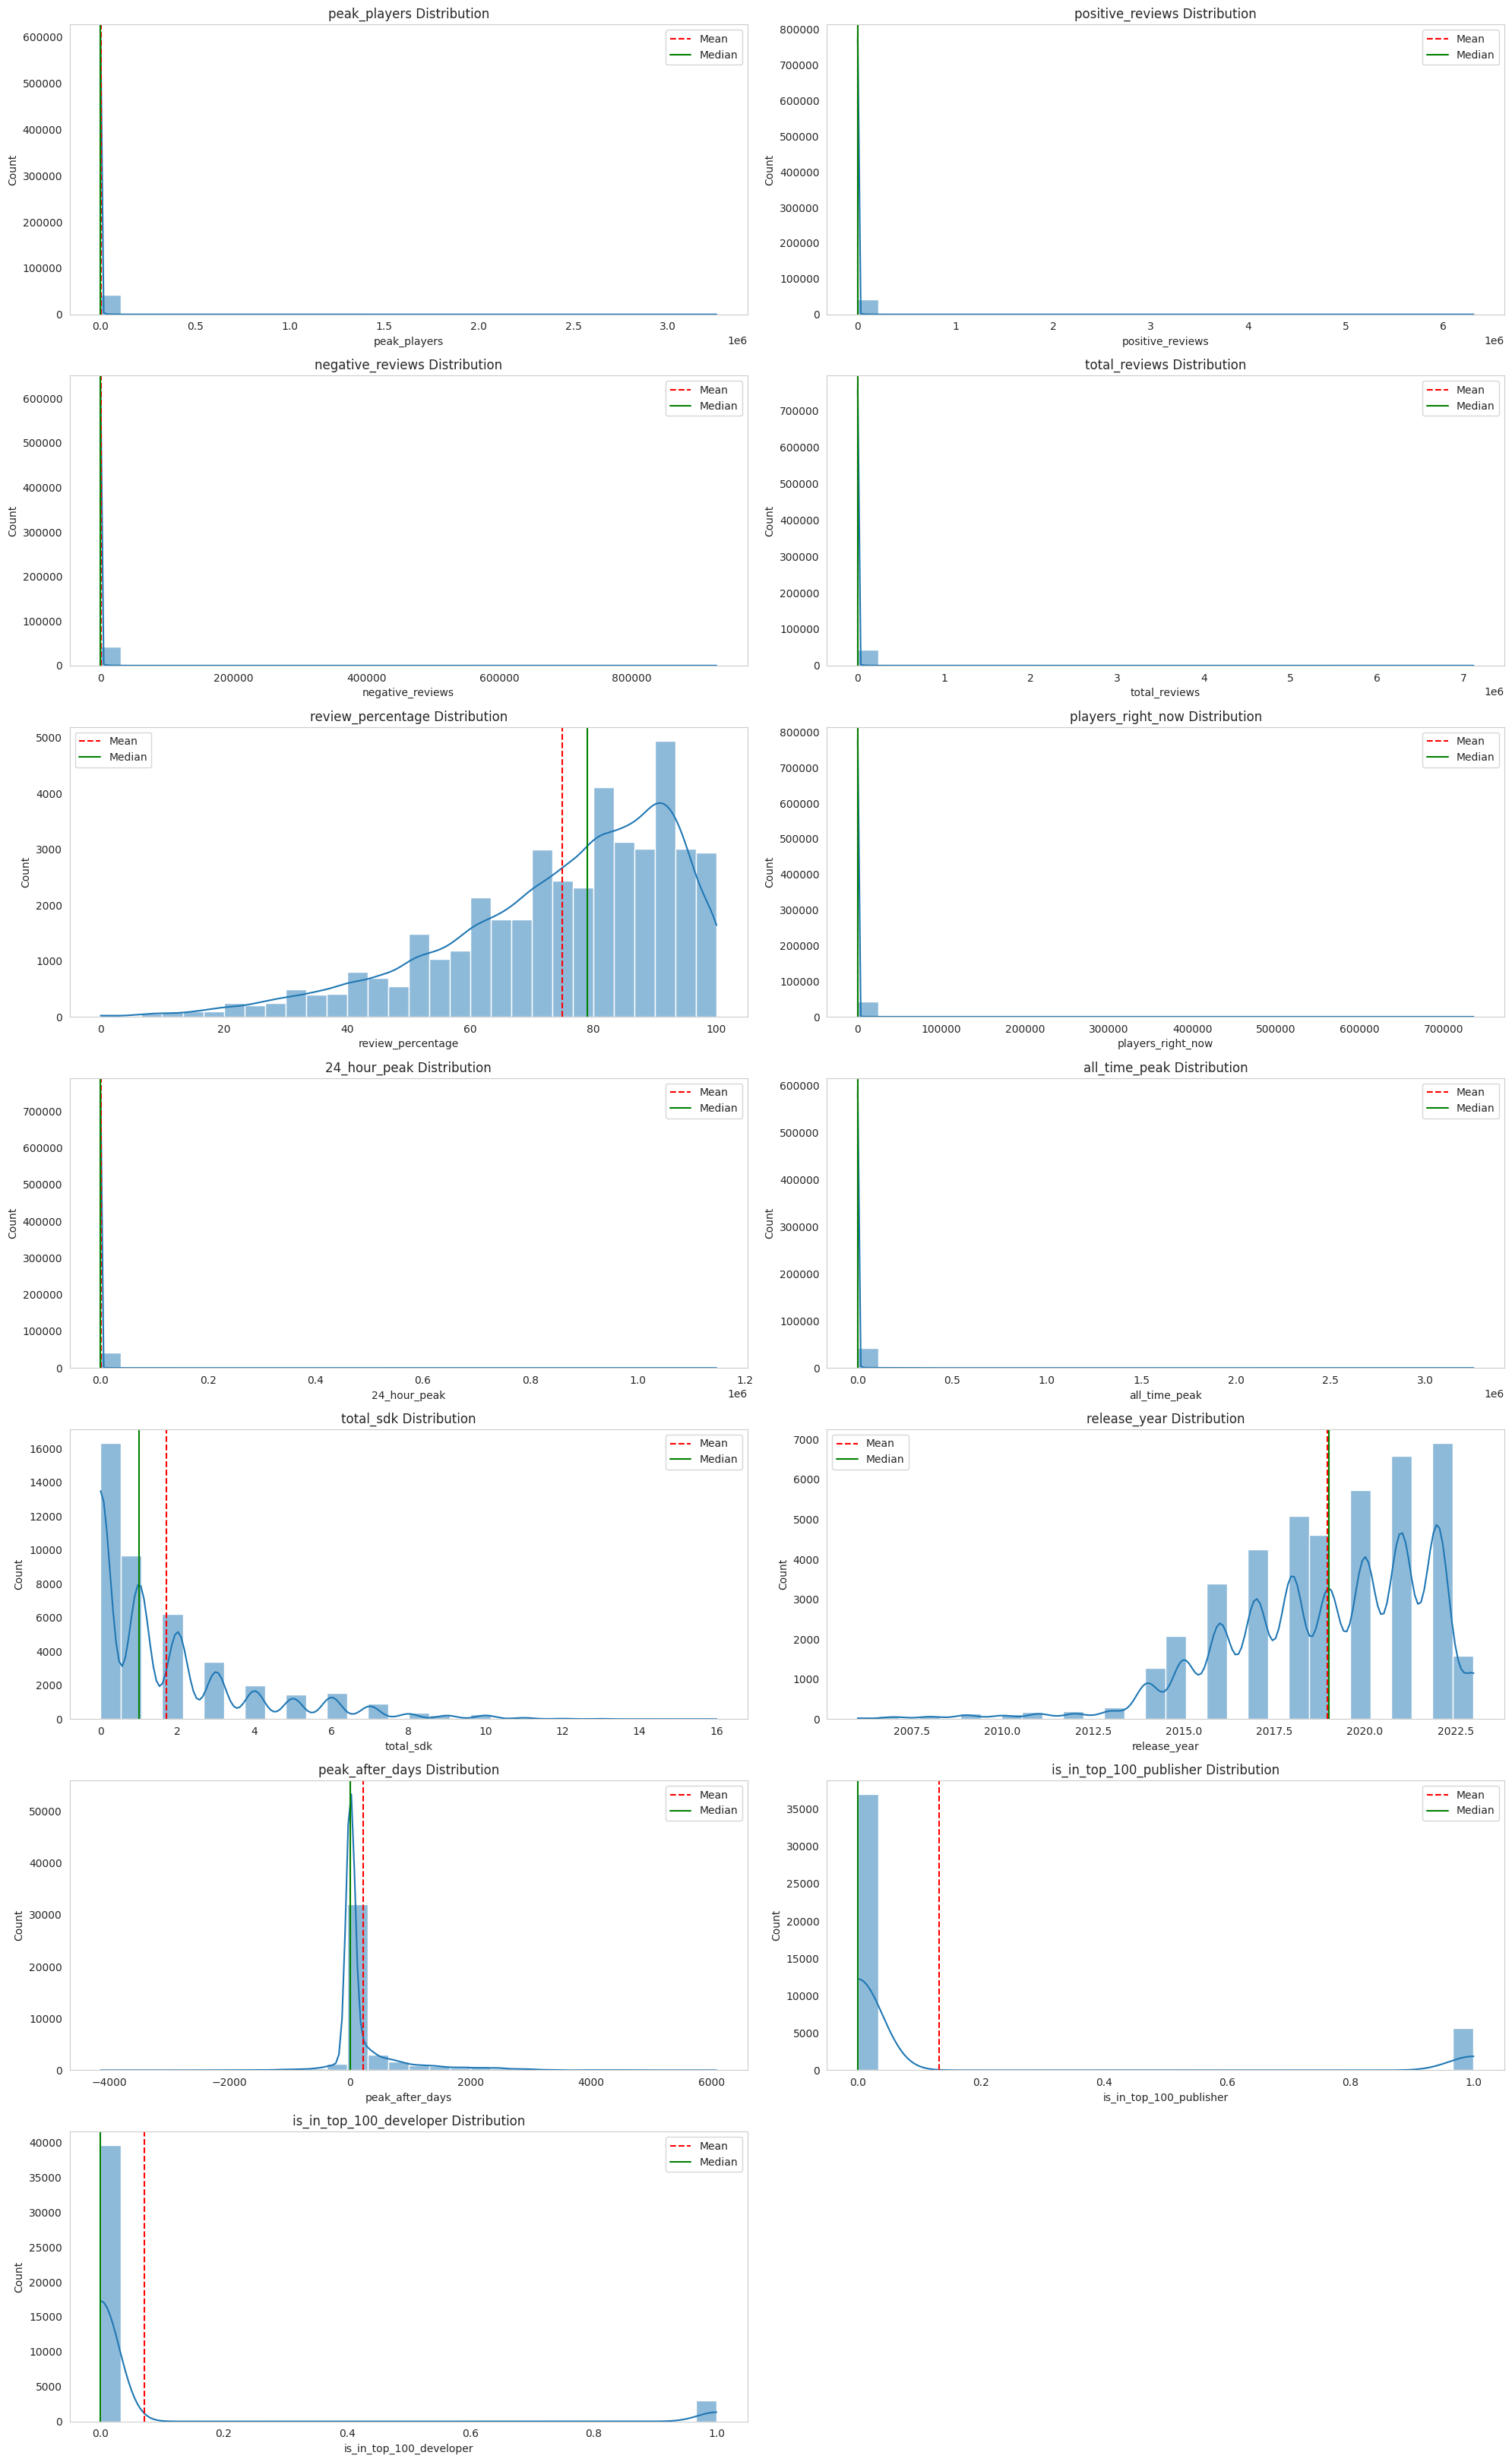

In [60]:
plt.figure(figsize=(20, len(numerical_variables) * 2.5))
plot_num(df, numerical_variables)

# Feature Scaling

In [61]:
def list_uniq(df, columns):
    for column in columns:
        print(f" {column} ".center(30, "#"))
        for i, val in enumerate(df[column].unique()):
            print(f"{i+1}. {val}")

        print()

In [62]:
list_uniq(df, categorical_variables)

########### engine ###########
1. GameMaker
2. RE_Engine
3. Unity
4. Unreal
5. Adobe_AIR
6. RenPy
7. Godot
8. RPGMaker
9. GoldSource
10. MonoGame
11. Frostbite
12. Unknown
13. Source
14. NScripter
15. ClickTeamFusion
16. AdventureGameStudio
17. Cocos
18. AntiCheat.EasyAntiCheat
19. KiriKiri
20. idTech3
21. VisualNovelMaker
22. Phaser
23. WolfRPGEditor
24. XNA
25. HashLink
26. Construct
27. FNA
28. CryEngine
29. Container.Electron
30. BlenderGameEngine
31. Love2D
32. AntiCheat.BlackCipher
33. GameGuru
34. AntiCheat.BattlEye
35. Solar2D
36. AntiCheat.XIGNCODE3
37. ApexEngine
38. AntiCheat.nProtect_GameGuard
39. Source2
40. Lime_OR_OpenFL
41. Pico8
42. Kex
43. Defold
44. HaemimontSol
45. TyranoBuilder
46. OGRE
47. Glacier
48. ChromeEngine
49. Build
50. Danmakufu
51. AppGameKit
52. AntiCheat.AntiCheatExpert
53. Clausewitz
54. Vision
55. UbisoftAnvil
56. Emulator.SCUMMVM
57. AntiCheat.EA_AntiCheat
58. Emulator.DOSBOX
59. Asura
60. Marmalade
61. Torque
62. Amazon_Lumberyard
63. PlayFirstPlay

In [63]:
X = df.drop('rating', axis=1)
y = df['rating']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [65]:
genre_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['genre'] = genre_encoder.fit_transform(X_train['genre'].values.reshape(-1, 1))[:, 0]
X_test['genre'] = genre_encoder.transform(X_test['genre'].values.reshape(-1, 1))[:, 0]

In [66]:
engine_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['engine'] = engine_encoder.fit_transform(X_train['engine'].values.reshape(-1, 1))[:, 0]
X_test['engine'] = engine_encoder.transform(X_test['engine'].values.reshape(-1, 1))[:, 0]

In [69]:
rs = RobustScaler()
X_train[numerical_variables] = rs.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = rs.transform(X_test[numerical_variables])

# Base Models

In [70]:
def adjusted_r2(r2, n, k):
    return r2 - (k - 1) / (n - k) * (1 - r2)

def root_mse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [71]:
models = {}
models['Random Forest'] = RandomForestRegressor()
models['Gradient Boosting'] = GradientBoostingRegressor()
models['Ada Boost'] = AdaBoostRegressor()
models['Ridge'] = Ridge()
models['Lasso'] = Lasso()
models['Linear Regression'] = LinearRegression()
models['Elastic Net'] = ElasticNet()
models['SVR'] = SVR()
models['Linear SVR'] = LinearSVR()
models['LGBM'] = LGBMRegressor(verbose=0)
models['XGB'] = XGBRegressor()
models['Cat Boost'] = CatBoostRegressor(verbose=0)
models['KNN'] = KNeighborsRegressor()

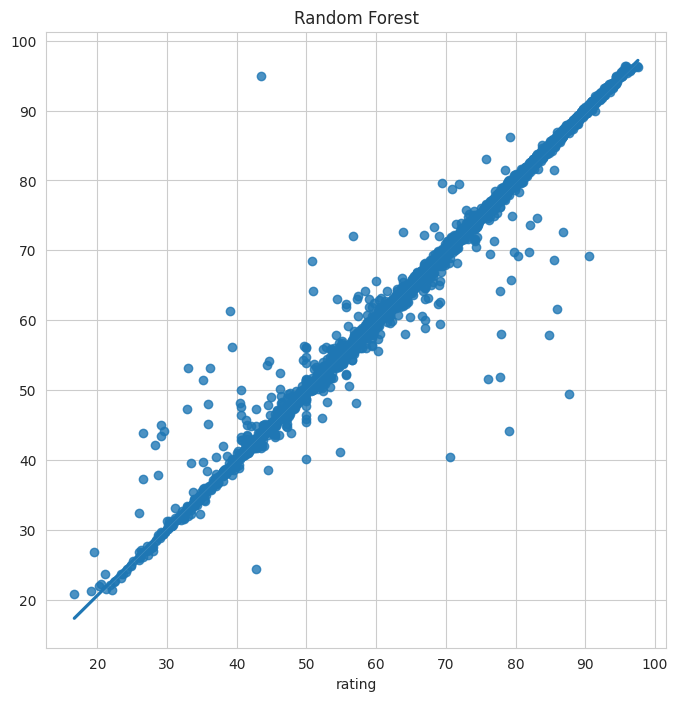

##################################################


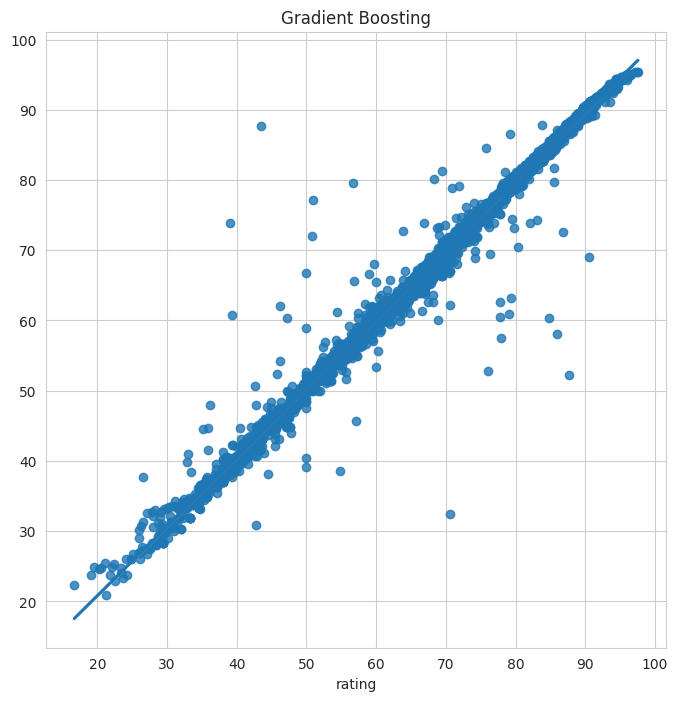

##################################################


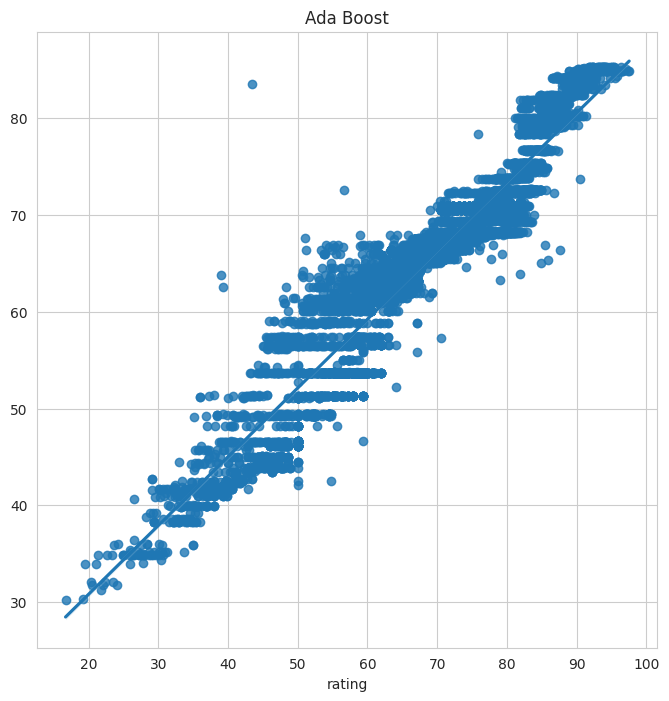

##################################################


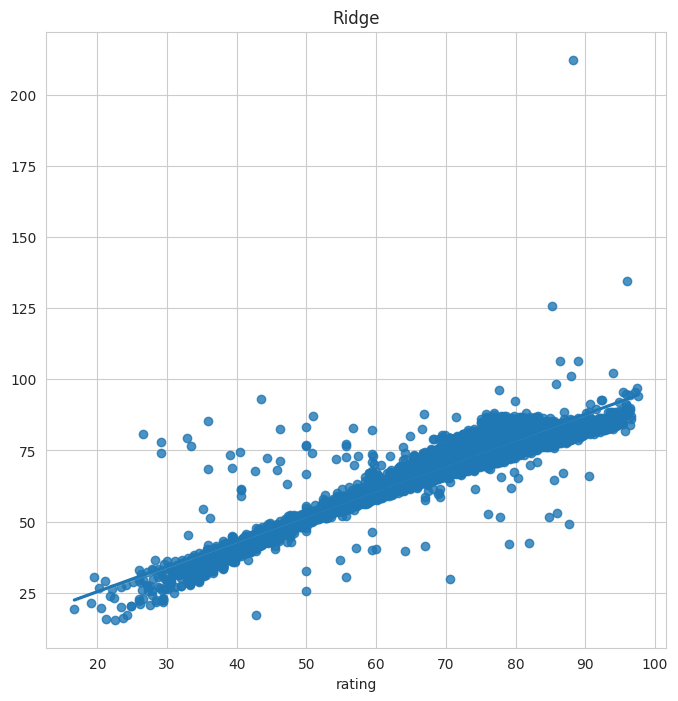

##################################################


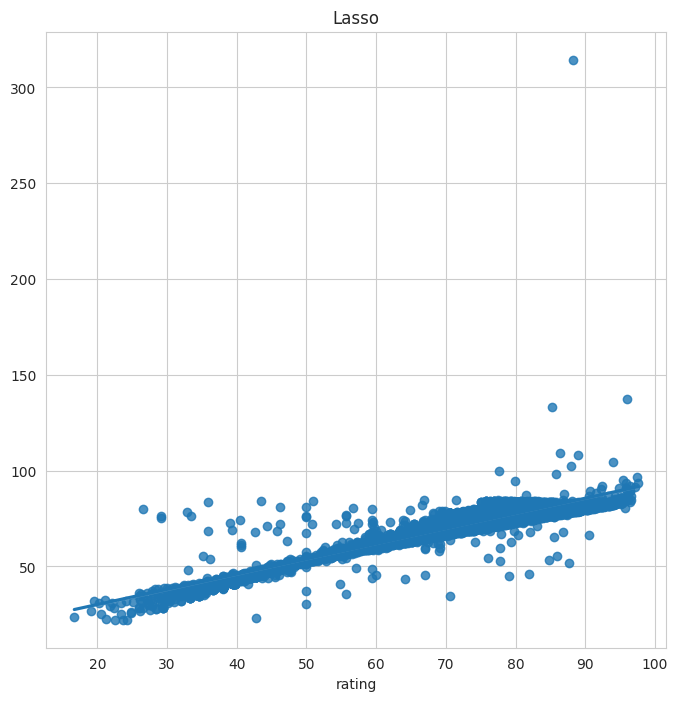

##################################################


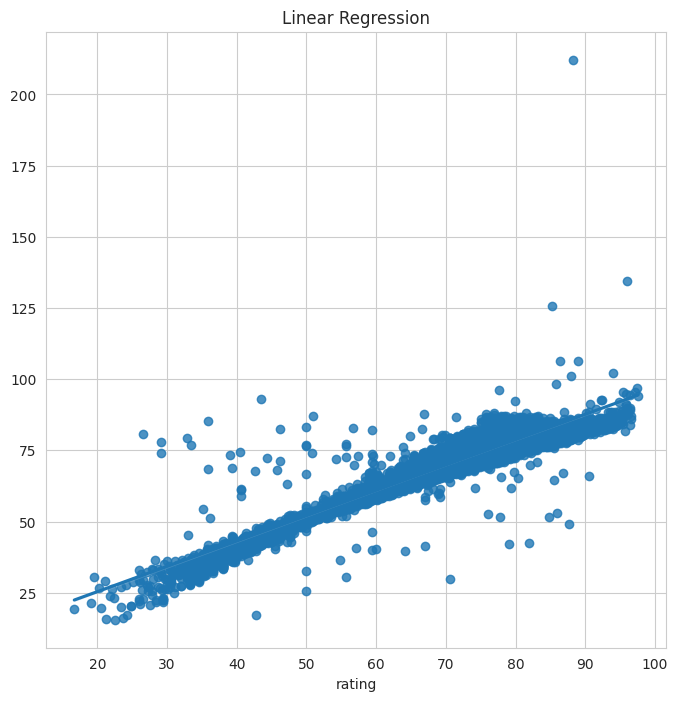

##################################################


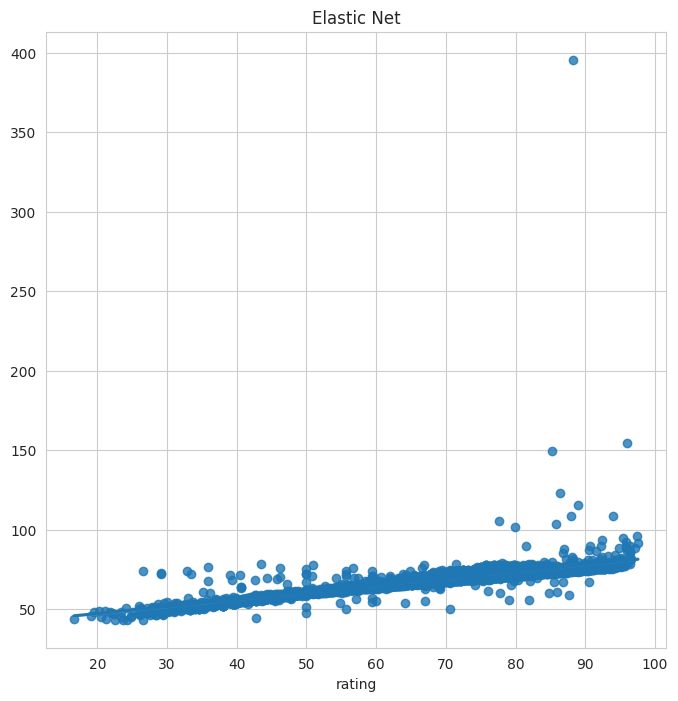

##################################################


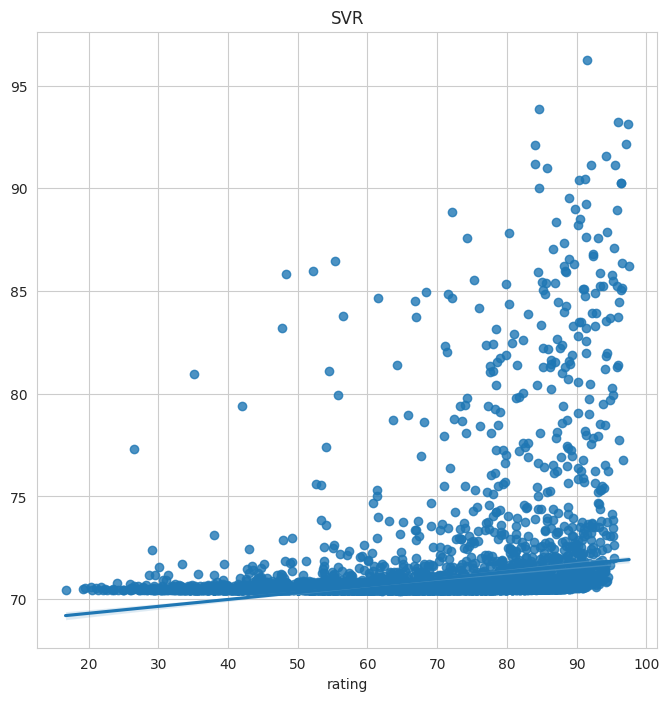

##################################################


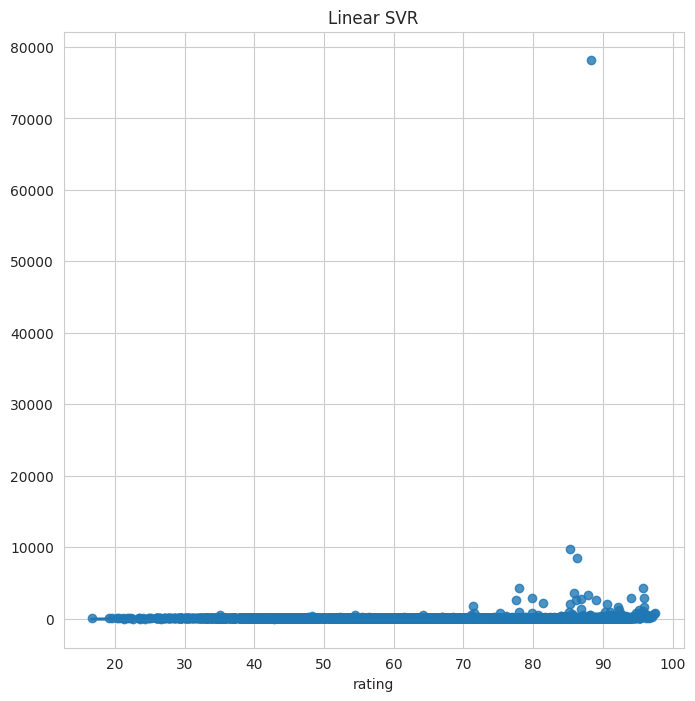

##################################################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011085 seconds.
You can set `force_col_wise=true` to remove the overhead.


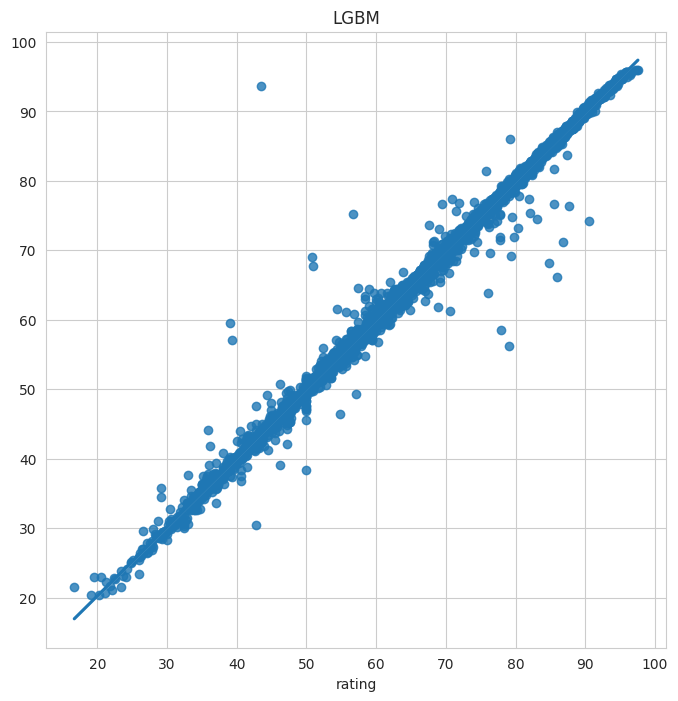

##################################################


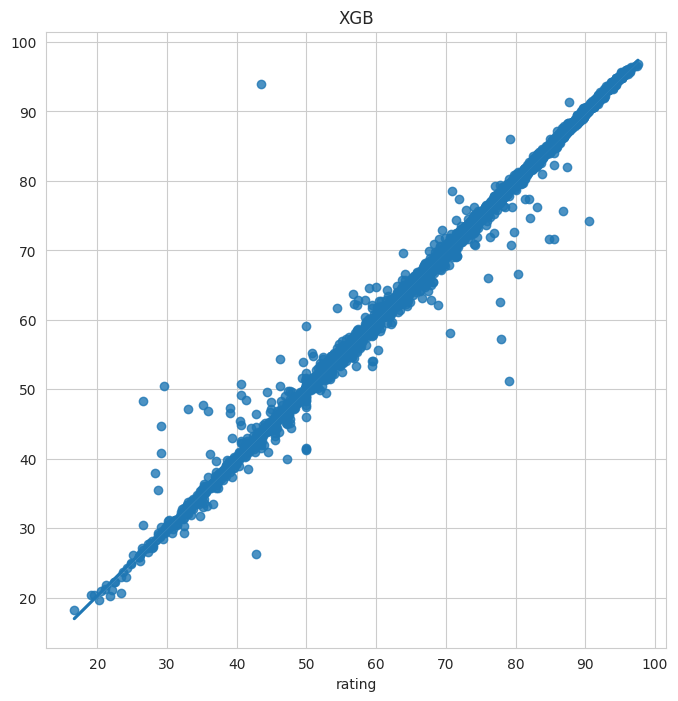

##################################################


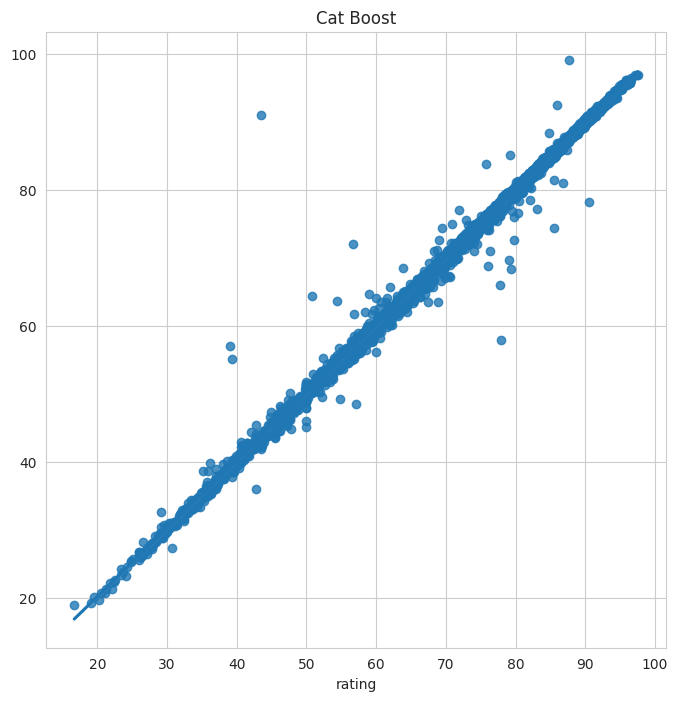

##################################################


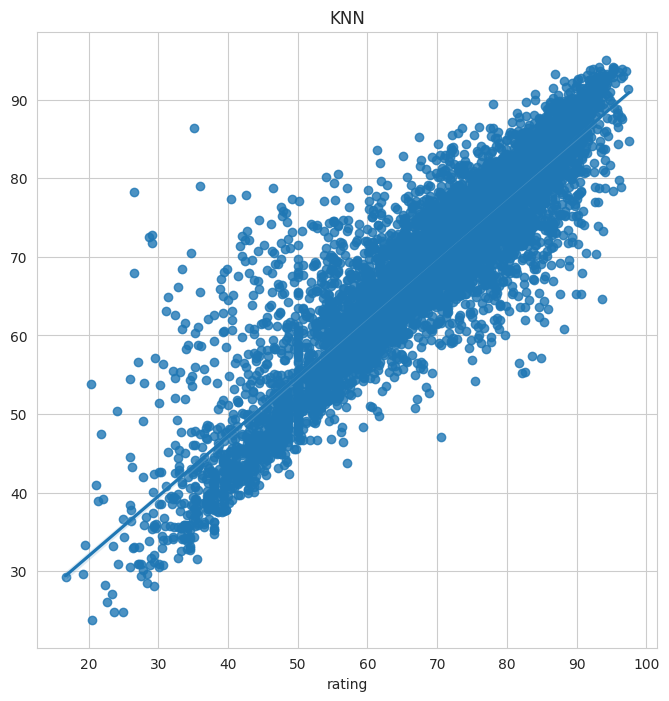

##################################################


In [72]:
train_time, test_time, r2, a_r2, mse, rmse, mae = {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time = time.time()
    models[key].fit(X_train, y_train)
    end_time = time.time()
    train_time[key] = end_time - start_time

    start_time = time.time()
    y_pred = models[key].predict(X_test)
    end_time = time.time()
    test_time[key] = end_time - start_time

    r2[key] = r2_score(y_test, y_pred)
    a_r2[key] = adjusted_r2(r2_score(y_test, y_pred), X_train.shape[0], X_train.shape[1])
    mse[key] = mean_squared_error(y_test, y_pred)
    rmse[key] = root_mse(y_test, y_pred)
    mae[key] = mean_absolute_error(y_test, y_pred)

    #pkl_filename = f"models/{key}.pkl"
    #with open(pkl_filename, "wb") as file:
    #    pickle.dump(models[key], file)

    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f"{key}")
    #save_fig(f"{key} Confusion Matrix")
    plt.show()
    
    print("#" * 50)

# Base Results

In [73]:
base_results_df = pd.DataFrame({"Train Time": train_time.values(),
                                "Test Time": test_time.values(),
                                "R2": r2.values(),
                                "Adjusted R2": a_r2.values(),
                                "MSE": mse.values(),
                                "RMSE": rmse.values(),
                                "MAE": mae.values()}, index=list(models.keys()))

base_results_df

,Train Time,Test Time,R2,Adjusted R2,MSE,RMSE,MAE
Random Forest,22.12,0.27,0.99,0.99,2.34,1.53,0.35
Gradient Boosting,6.19,0.02,0.99,0.99,2.34,1.53,0.54
Ada Boost,3.26,0.05,0.81,0.81,36.11,6.01,5.02
Ridge,0.03,0.01,0.88,0.88,23.25,4.82,3.22
Lasso,0.13,0.04,0.84,0.84,30.22,5.50,3.67
Linear Regression,0.04,0.04,0.88,0.88,23.25,4.82,3.22
Elastic Net,1.01,0.01,0.59,0.59,78.21,8.84,6.47
SVR,72.32,17.80,0.02,0.02,186.63,13.66,10.65
Linear SVR,4.81,0.00,-3963.86,-3965.49,752044.96,867.21,24.15
LGBM,1.31,0.02,0.99,0.99,1.30,1.14,0.40


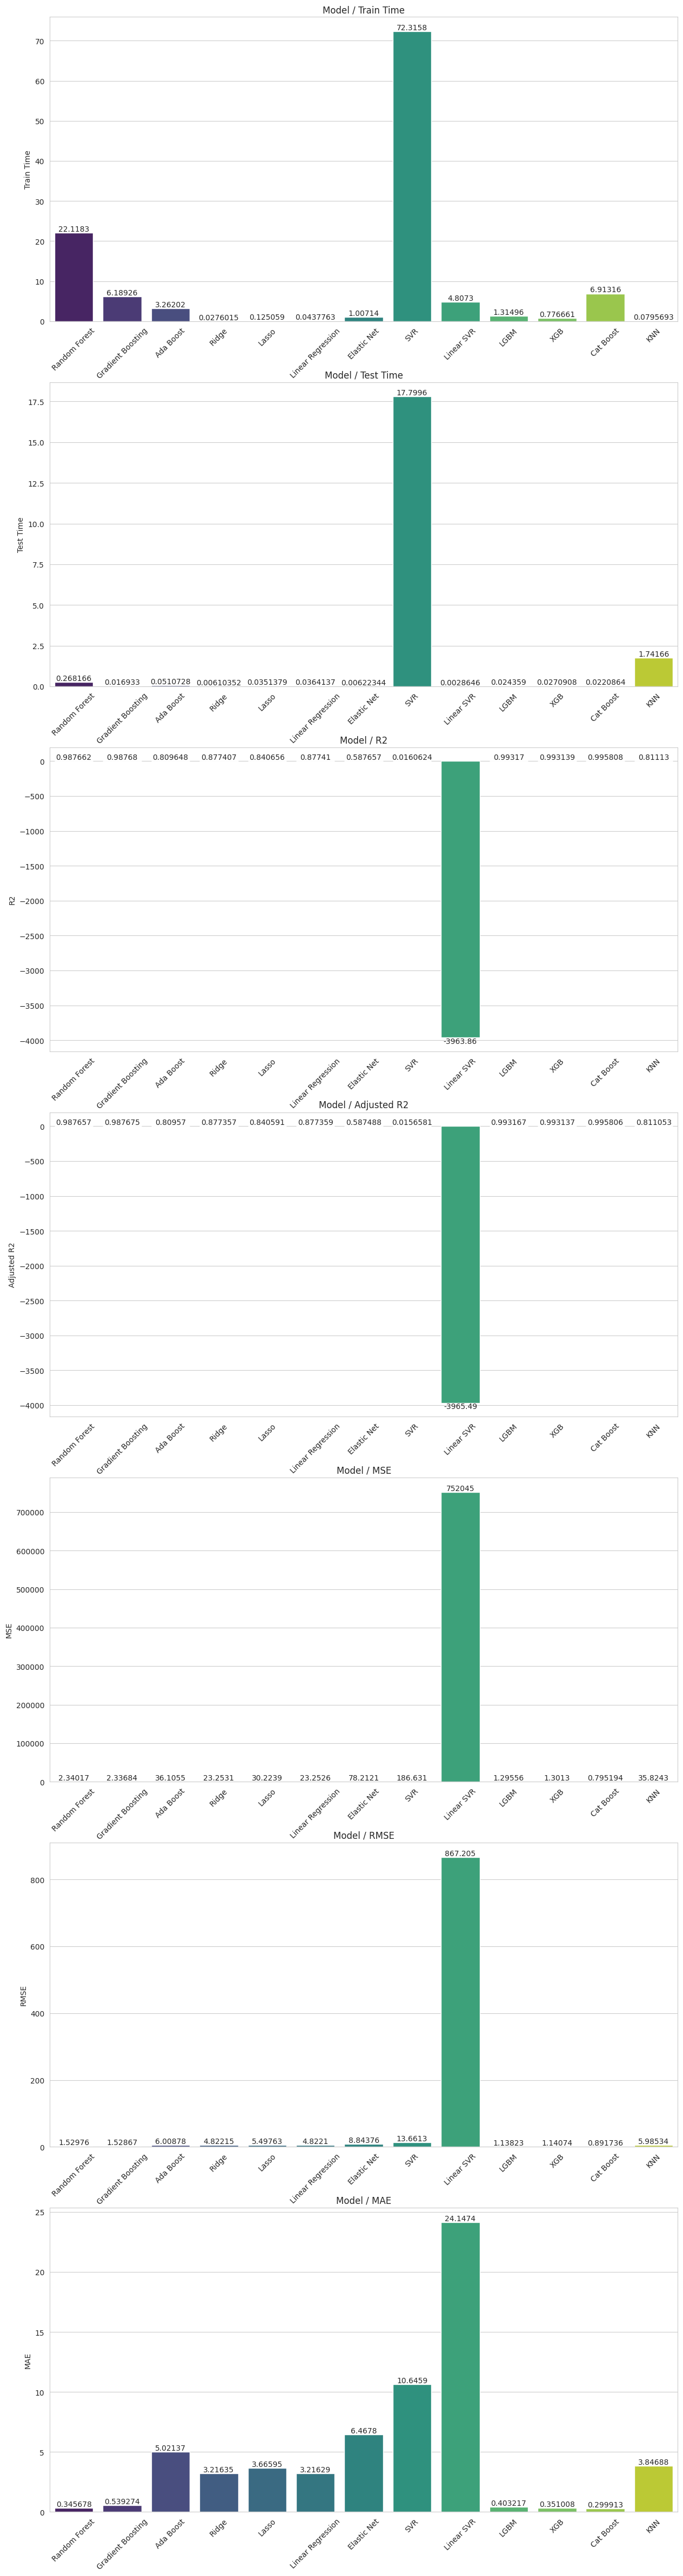

In [74]:
plt.figure(figsize=(15, 60))

plt.subplot(711)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Train Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Train Time")

plt.subplot(712)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Test Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Test Time")

plt.subplot(713)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / R2")

plt.subplot(714)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Adjusted R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Adjusted R2")

plt.subplot(715)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="MSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MSE")

plt.subplot(716)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="RMSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / RMSE")

plt.subplot(717)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="MAE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MAE")

plt.show()

# Feature Selection

In [75]:
def plot_correlation_table(df):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidth=0.6, annot=True, robust=True, center=0, square=True)
    plt.title("Correlation Table")
    plt.show()

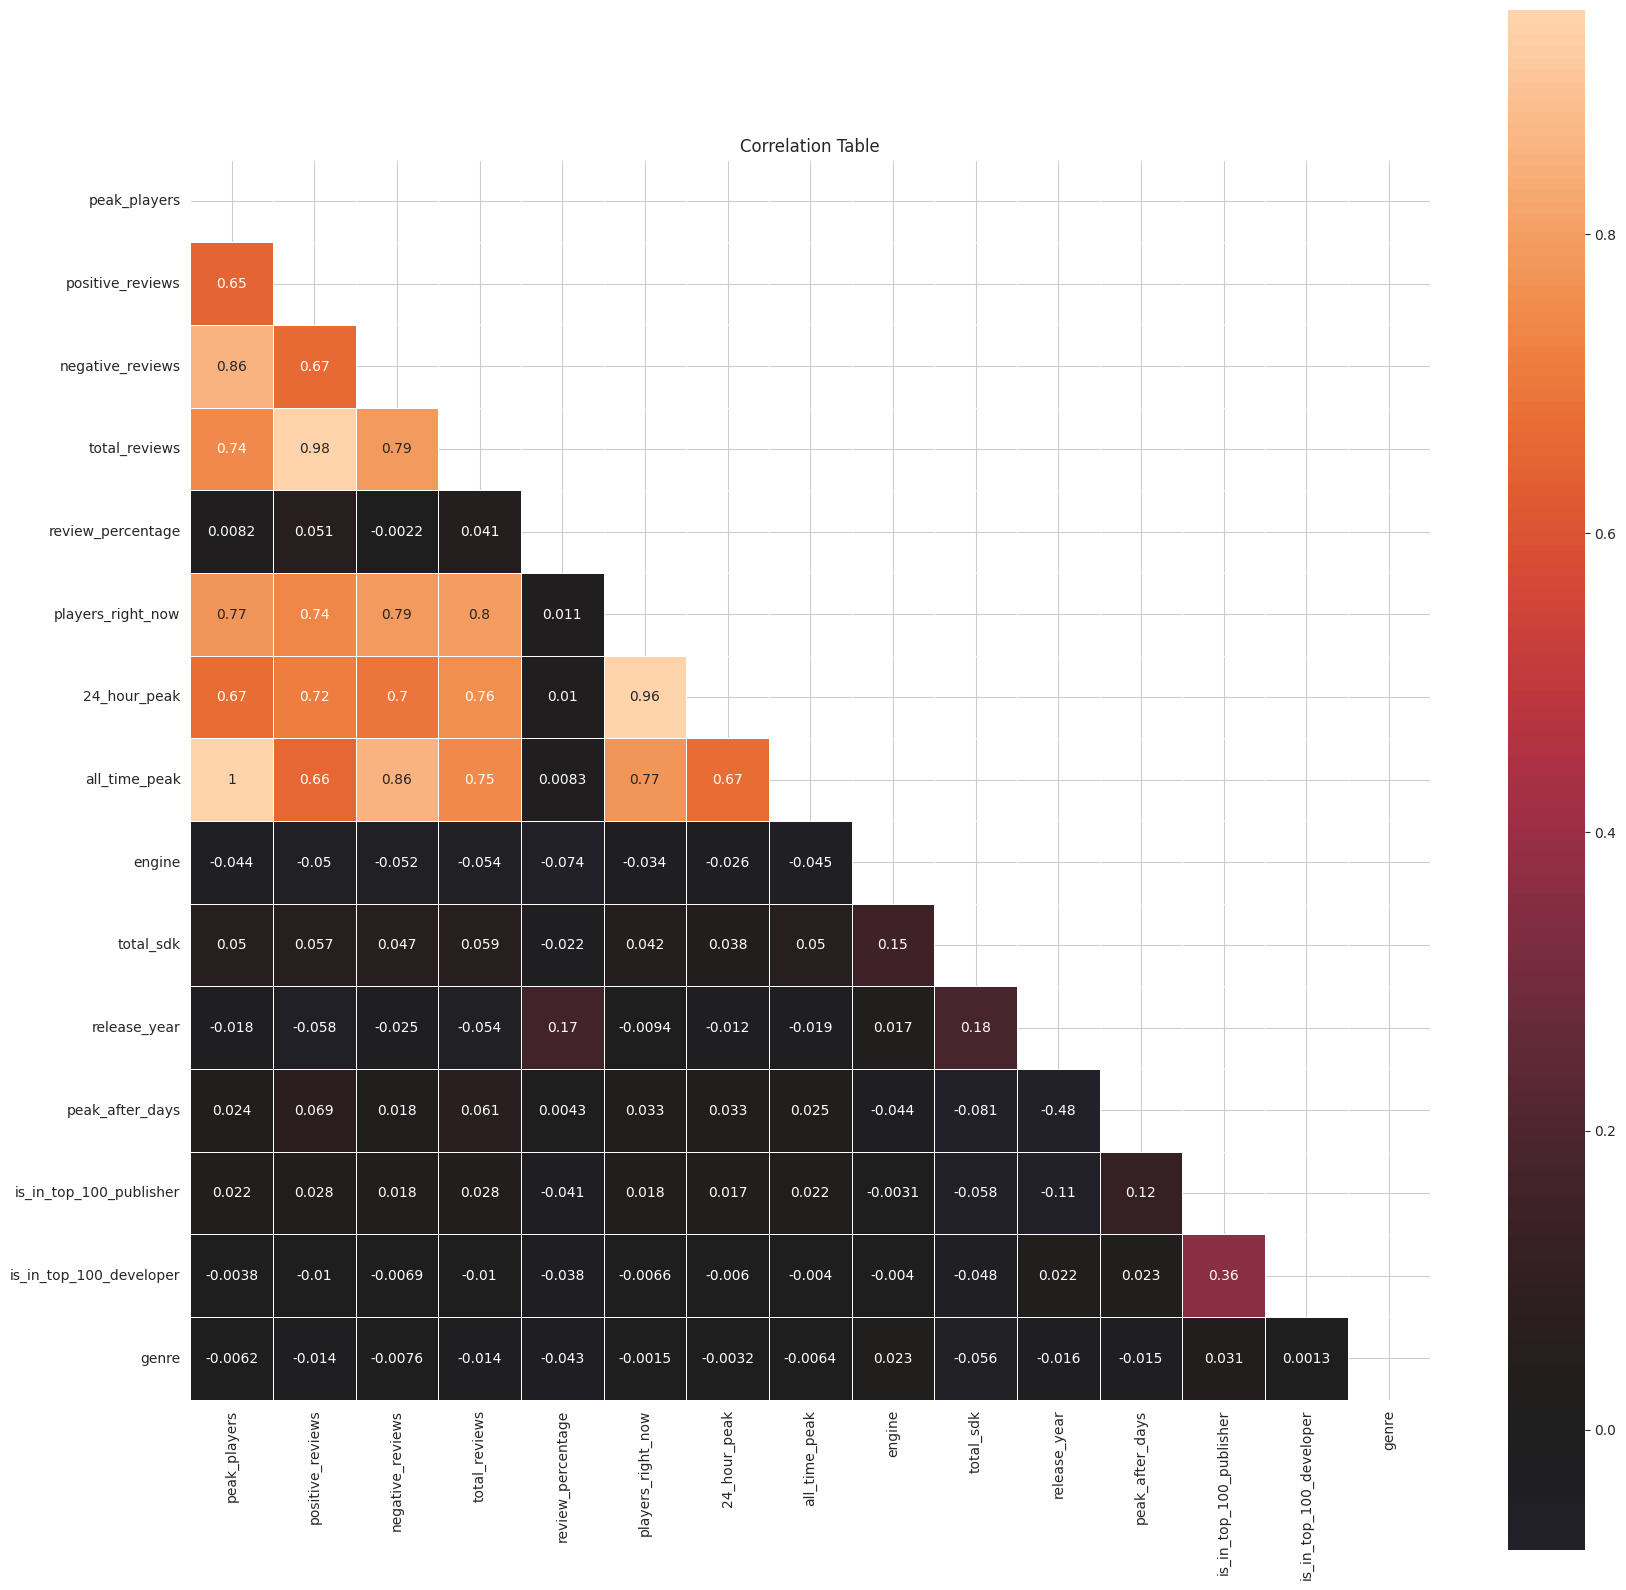

In [77]:
plot_correlation_table(X_train)

In [78]:
f_value = f_regression(X_train, y_train)

for feature in zip(X_train.columns, f_value[0]):
    print(feature)

('peak_players', 36.601255467904046)
('positive_reviews', 351.60215275214154)
('negative_reviews', 10.333141250325454)
('total_reviews', 261.01741303012705)
('review_percentage', 254831.43518392975)
('players_right_now', 29.866923581844993)
('24_hour_peak', 25.3753612372899)
('all_time_peak', 36.57846198372152)
('engine', 168.4314337426683)
('total_sdk', 2.9069753420839284)
('release_year', 283.05683208681324)
('peak_after_days', 66.67261300221334)
('is_in_top_100_publisher', 5.477819119517015)
('is_in_top_100_developer', 64.08431932353868)
('genre', 36.3937778419145)


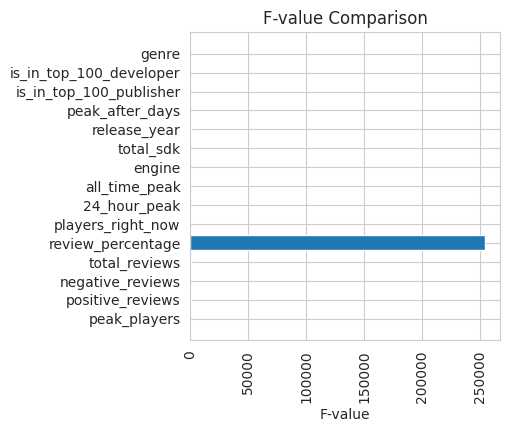

In [82]:
plt.figure(figsize=(4, 4))
plt.barh(y=X_train.columns, width=f_value[0])
plt.xticks(rotation="vertical")
plt.xlabel("F-value")
plt.title("F-value Comparison")
plt.show()

In [83]:
MI_score = mutual_info_regression(X_train, y_train, random_state=42)

for feature in zip(X_train.columns, MI_score):
    print(feature)

('peak_players', 0.2835994383600684)
('positive_reviews', 2.313134954506611)
('negative_reviews', 1.6377071318596474)
('total_reviews', 2.3430901999371203)
('review_percentage', 2.5200291858202064)
('players_right_now', 0.12151445798725691)
('24_hour_peak', 0.21059404066531506)
('all_time_peak', 0.26256584513974435)
('engine', 0.029082513553864153)
('total_sdk', 0.010935338484703294)
('release_year', 0.054918813869281546)
('peak_after_days', 0.02463178120028875)
('is_in_top_100_publisher', 0.0040530844377100195)
('is_in_top_100_developer', 0.003425091556068738)
('genre', 0.016665846073033563)


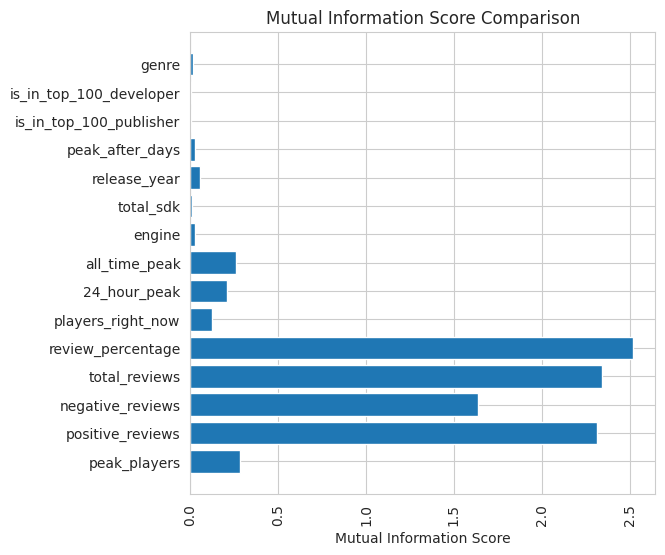

In [84]:
plt.figure(figsize=(6, 6))
plt.barh(y=X_train.columns, width=MI_score)
plt.xticks(rotation="vertical")
plt.yticks(rotation="horizontal")
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Score Comparison")
plt.show()

In [85]:
skb = SelectKBest(score_func=f_regression, k=5)                  
X_data_new = skb.fit_transform(X_train, y_train)

print('Number of features before feature selection: {}'.format(X_train.shape[1]))
print('Number of features after feature selection: {}'.format(X_data_new.shape[1]))

for feature_list_index in skb.get_support(indices=True):
    print('- ' + X_train.columns[feature_list_index])

Number of features before feature selection: 15
Number of features after feature selection: 5
- positive_reviews
- total_reviews
- review_percentage
- engine
- release_year


In [86]:
X_train_new = X_train[['positive_reviews', 'total_reviews', 'review_percentage', 'engine', 'release_year']]
X_test_new = X_test[['positive_reviews', 'total_reviews', 'review_percentage', 'engine', 'release_year']]

# Feature-Selected Models

In [87]:
f_models = {}
f_models['Random Forest'] = RandomForestRegressor()
f_models['Gradient Boosting'] = GradientBoostingRegressor()
f_models['Ada Boost'] = AdaBoostRegressor()
f_models['Ridge'] = Ridge()
f_models['Lasso'] = Lasso()
f_models['Linear Regression'] = LinearRegression()
f_models['Elastic Net'] = ElasticNet()
f_models['SVR'] = SVR()
f_models['Linear SVR'] = LinearSVR()
f_models['LGBM'] = LGBMRegressor(verbose=0)
f_models['XGB'] = XGBRegressor()
f_models['Cat Boost'] = CatBoostRegressor(verbose=0)
f_models['KNN'] = KNeighborsRegressor()

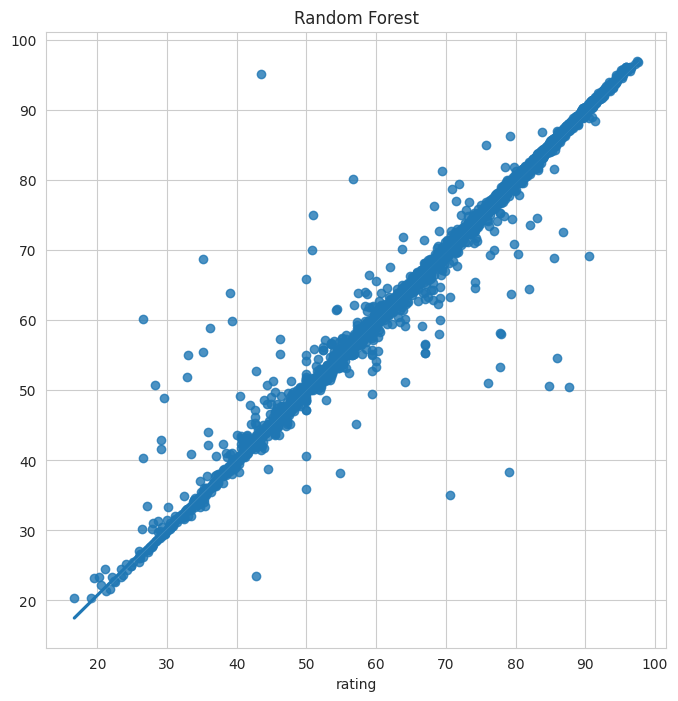

##################################################


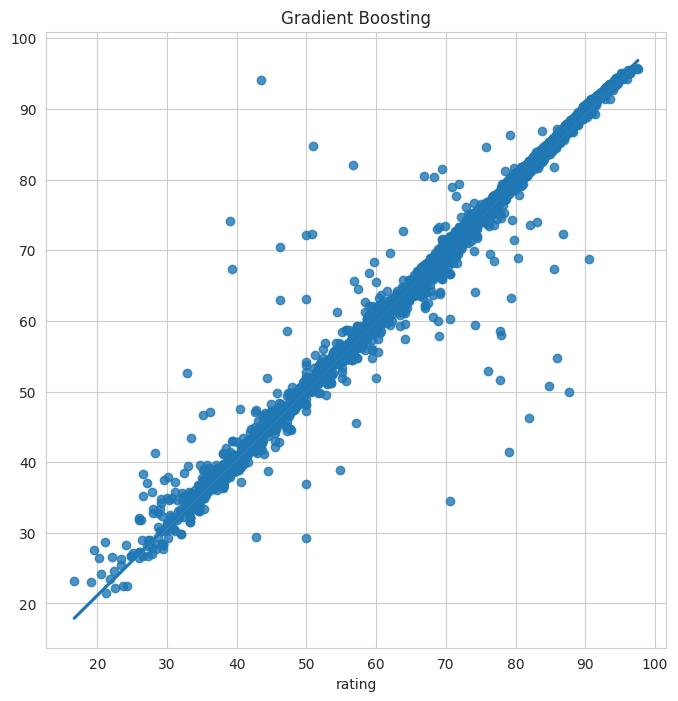

##################################################


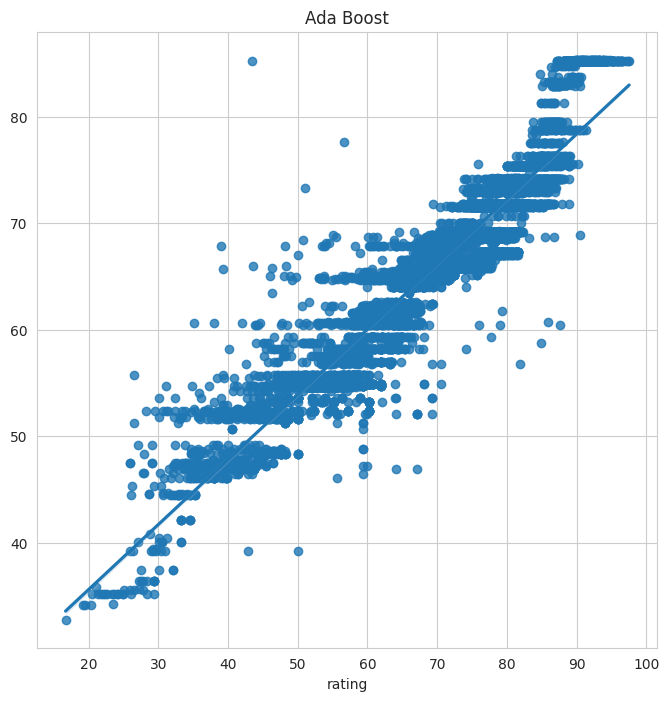

##################################################


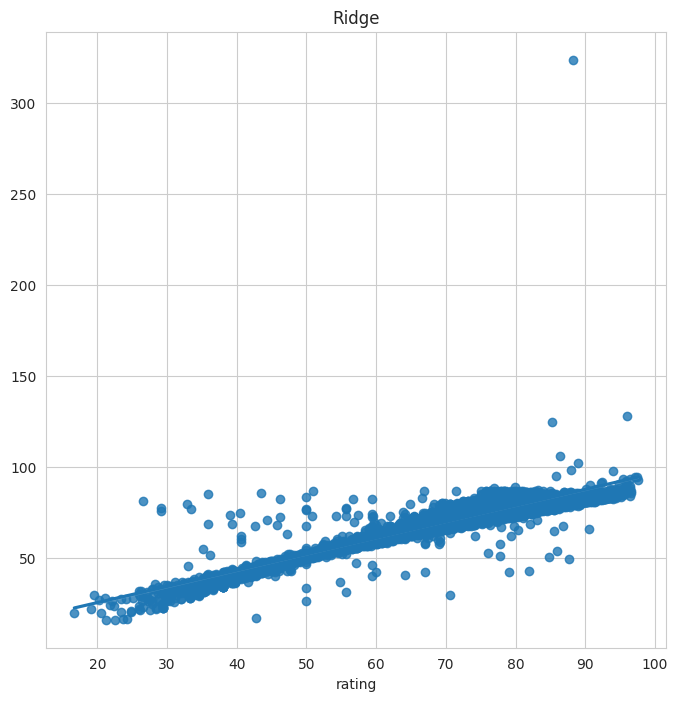

##################################################


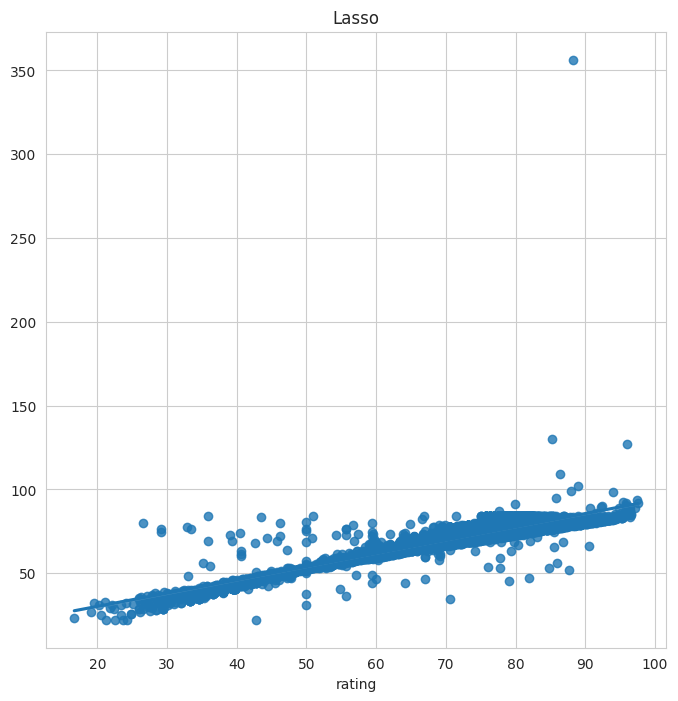

##################################################


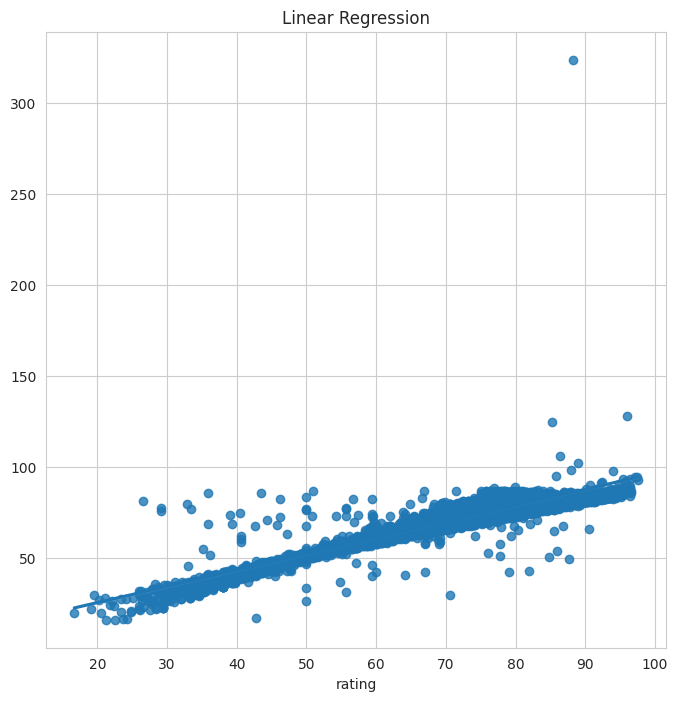

##################################################


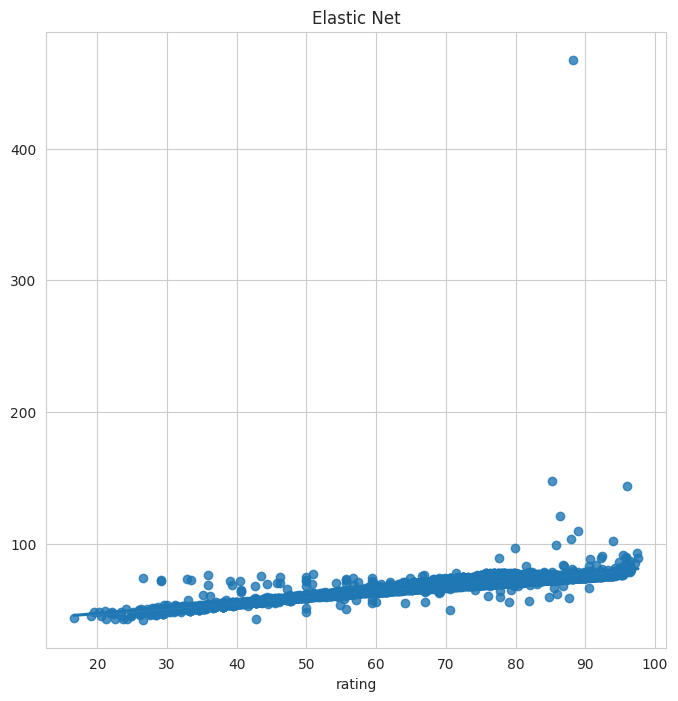

##################################################


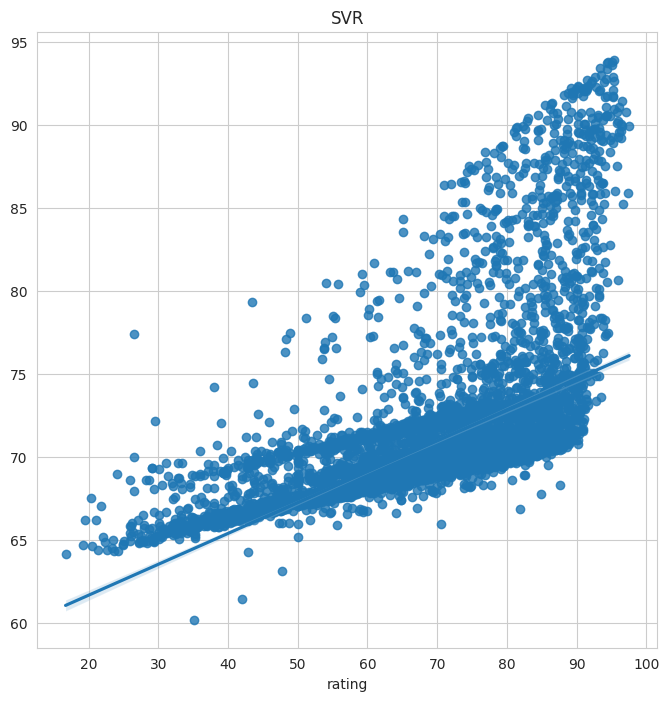

##################################################


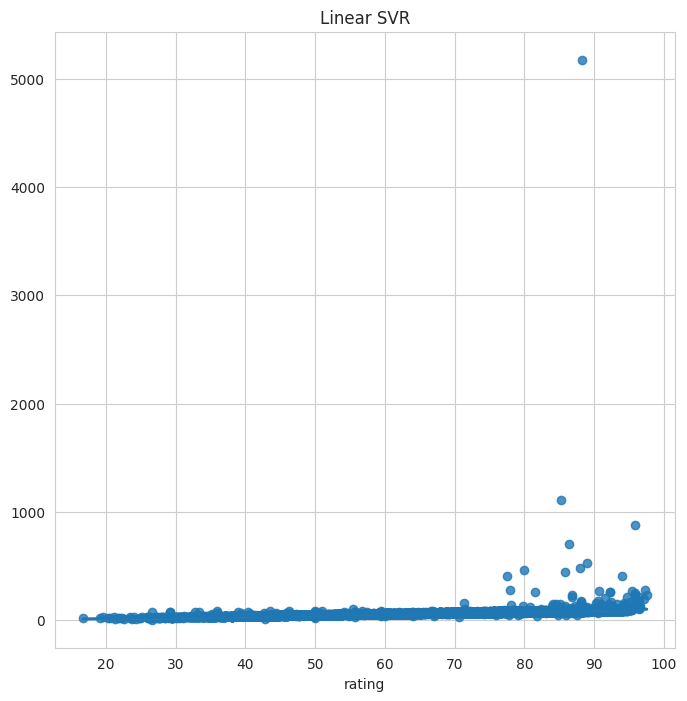

##################################################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_col_wise=true` to remove the overhead.


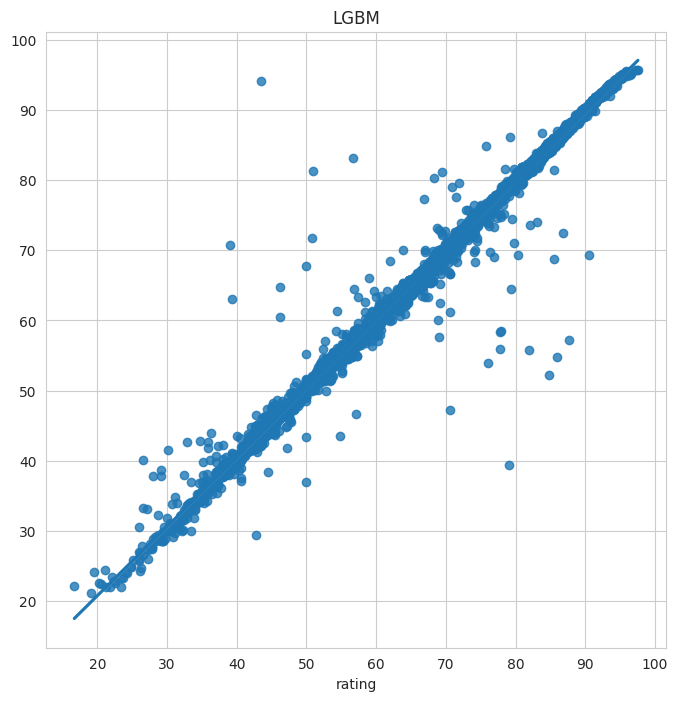

##################################################


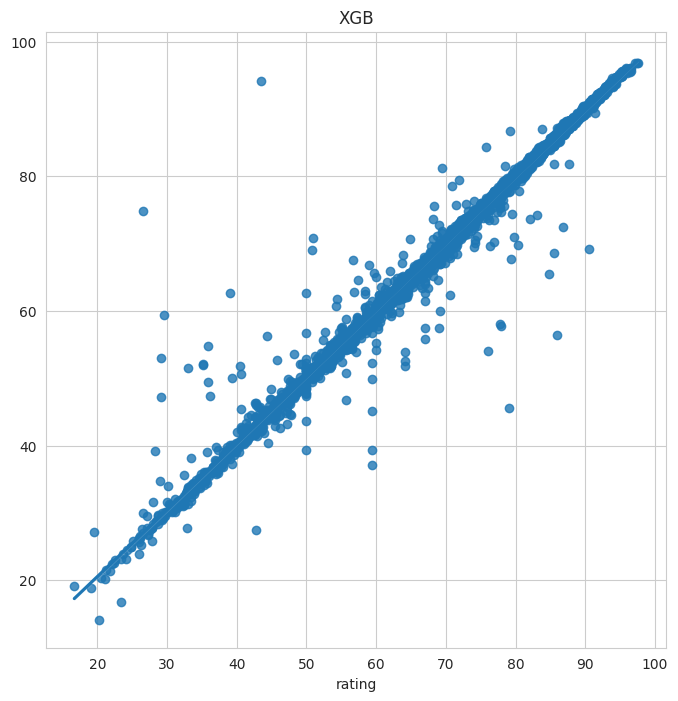

##################################################


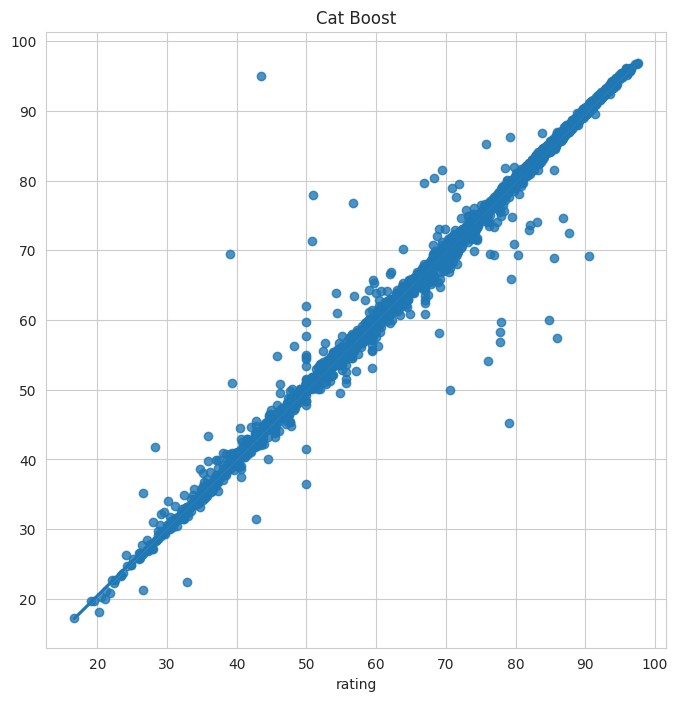

##################################################


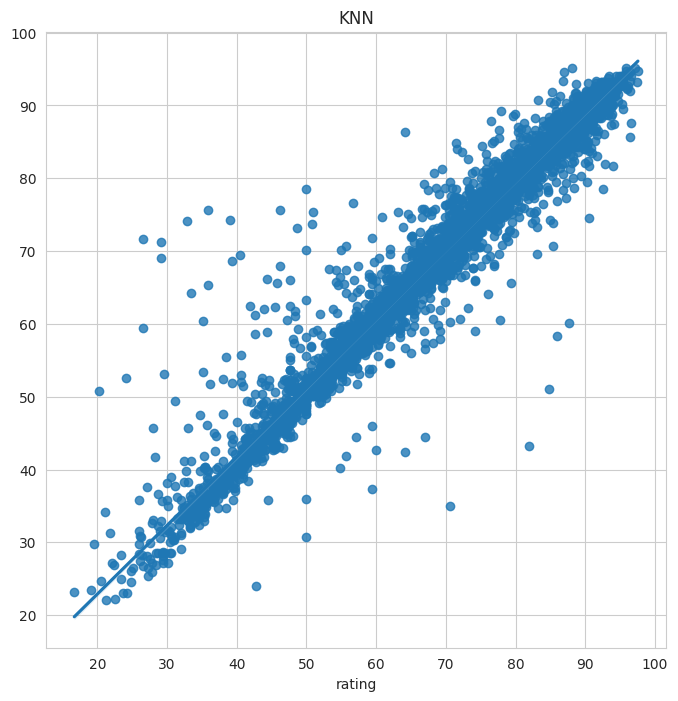

##################################################


In [88]:
f_train_time, f_test_time, f_r2, f_a_r2, f_mse, f_rmse, f_mae = {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time = time.time()
    f_models[key].fit(X_train_new, y_train)
    end_time = time.time()
    f_train_time[key] = end_time - start_time

    start_time = time.time()
    y_pred = f_models[key].predict(X_test_new)
    end_time = time.time()
    f_test_time[key] = end_time - start_time

    f_r2[key] = r2_score(y_test, y_pred)
    f_a_r2[key] = adjusted_r2(r2_score(y_test, y_pred), X_train_new.shape[0], X_train_new.shape[1])
    f_mse[key] = mean_squared_error(y_test, y_pred)
    f_rmse[key] = root_mse(y_test, y_pred)
    f_mae[key] = mean_absolute_error(y_test, y_pred)

    #pkl_filename = f"models/{key}.pkl"
    #with open(pkl_filename, "wb") as file:
    #    pickle.dump(models[key], file)

    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f"{key}")
    #save_fig(f"{key} Confusion Matrix")
    plt.show()
    
    print("#" * 50)

# Feature-Selected Models Results

In [89]:
f_results_df = pd.DataFrame({"Train Time": f_train_time.values(),
                           "Test Time": f_test_time.values(),
                           "R2": f_r2.values(),
                           "Adjusted R2": f_a_r2.values(),
                           "MSE": f_mse.values(),
                           "RMSE": f_rmse.values(),
                           "MAE": f_mae.values()}, index=list(f_models.keys()))

f_results_df

,Train Time,Test Time,R2,Adjusted R2,MSE,RMSE,MAE
Random Forest,8.37,0.25,0.98,0.98,3.27,1.81,0.39
Gradient Boosting,2.64,0.02,0.98,0.98,3.45,1.86,0.61
Ada Boost,1.47,0.05,0.74,0.74,48.78,6.98,5.80
Ridge,0.01,0.01,0.85,0.85,28.11,5.30,3.26
Lasso,0.22,0.00,0.83,0.83,32.78,5.73,3.70
Linear Regression,0.01,0.00,0.85,0.85,28.10,5.30,3.26
Elastic Net,0.09,0.00,0.56,0.56,84.09,9.17,6.49
SVR,66.43,14.12,0.25,0.25,142.66,11.94,9.26
Linear SVR,2.99,0.00,-17.20,-17.20,3452.21,58.76,4.65
LGBM,0.83,0.02,0.99,0.99,2.60,1.61,0.47


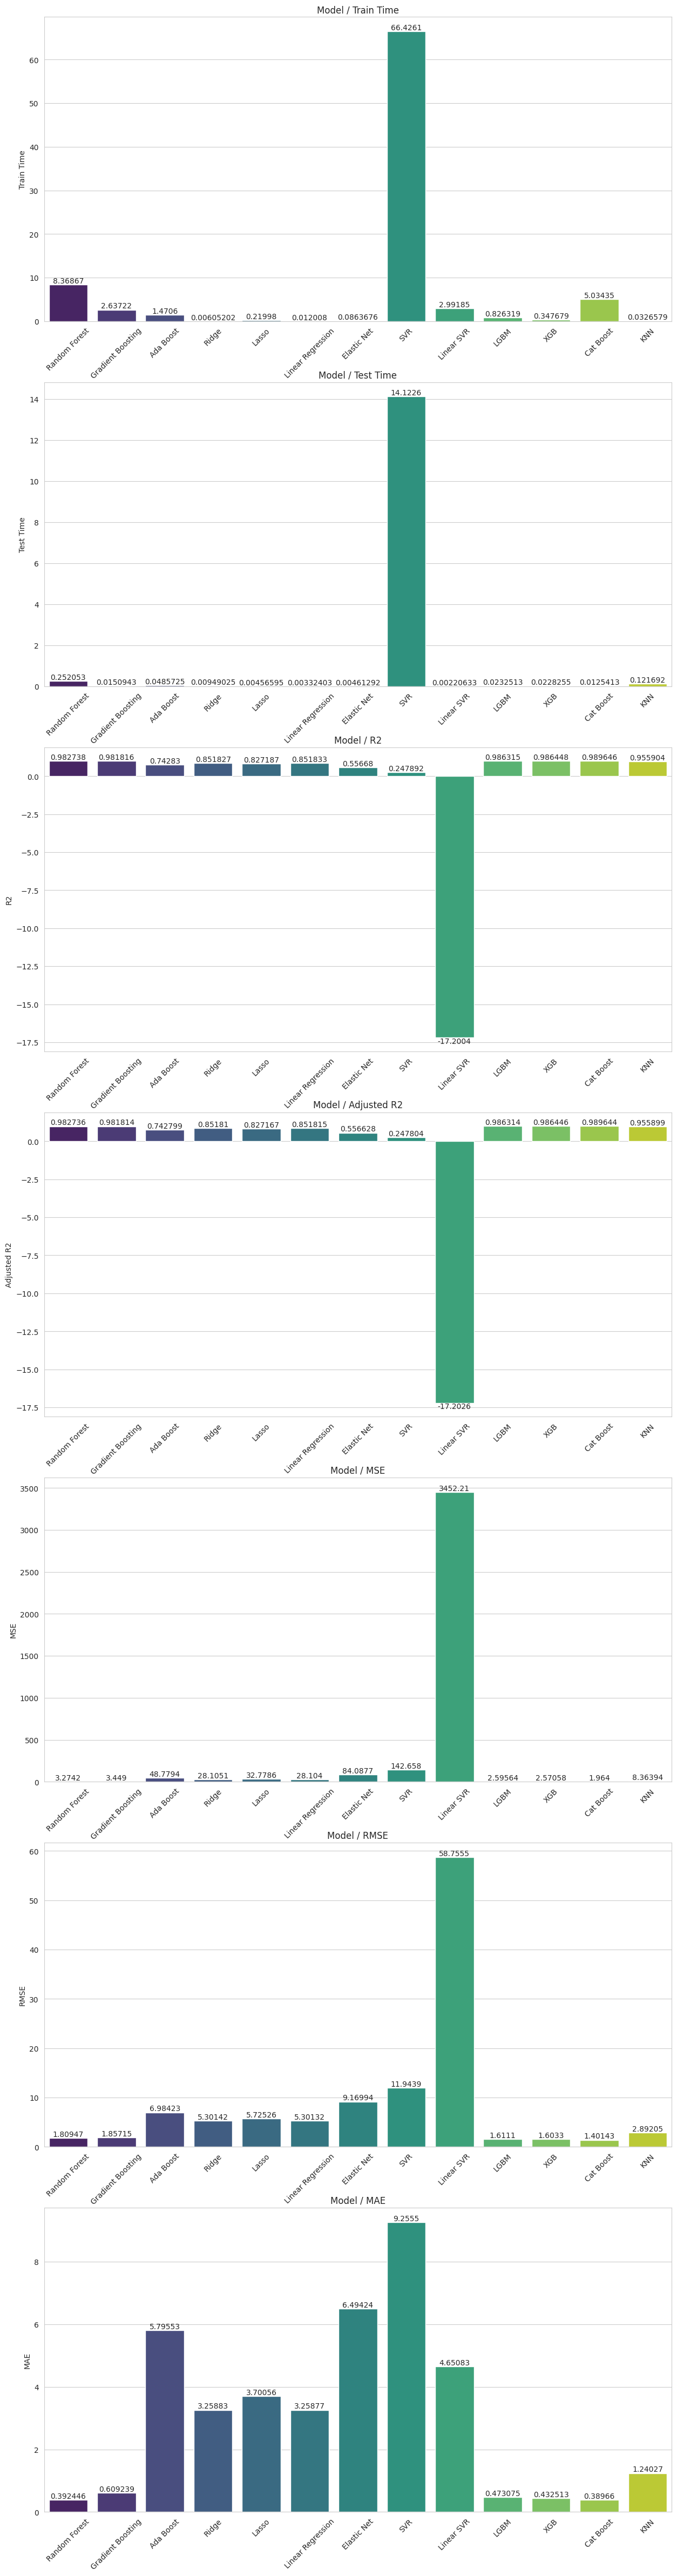

In [90]:
plt.figure(figsize=(15, 60))

plt.subplot(711)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Train Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Train Time")

plt.subplot(712)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Test Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Test Time")

plt.subplot(713)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / R2")

plt.subplot(714)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Adjusted R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Adjusted R2")

plt.subplot(715)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="MSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MSE")

plt.subplot(716)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="RMSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / RMSE")

plt.subplot(717)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="MAE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MAE")

plt.show()

# Hyperparameter Tuning

In [91]:
rf_params = {
    "bootstrap": [True, False],
    "max_depth": [2, 4, 6, 8],
    "max_features": [0.1, 0.2, 0.5],
    "min_samples_split": [0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 250, 500, 1000]
}

rf_model = RandomForestRegressor()

cv = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

Best hyperparams:
 {'n_estimators': 500, 'min_samples_split': 0.2, 'max_features': 0.5, 'max_depth': 8, 'bootstrap': False}
Best score:  0.864236970934278


In [92]:
lgbm_params ={
    'learning_rate':[0.01, 0.1, 0.5],
    'n_estimators':[100,500,1000,1250],
    'colsample_bytree': [0.3, 0.7, 1],
    'max_bin':[100, 250, 300],
    'max_depth':[2, 3, 4, 6],
    'min_data_in_leaf':[10, 20, 50],
    'reg_alpha': [1, 2, 5, 10],
    'reg_lambda': [1, 2, 5, 10],
    'min_gain_to_split':[1, 3, 5, 10]
}

lgbm_model = LGBMRegressor()
cv = RandomizedSearchCV(lgbm_model, lgbm_params, n_iter=10, cv=3, n_jobs=-1, verbose=-1)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] min

In [93]:
xgb_params = {
    'n_estimators': [100, 250, 500, 1000],
    'booster':['gbtree', 'gblinear'],
    'learning_rate':[0.01, 0.1, 0.5],
    'max_depth':[2, 3, 5, 7, 10],
    'subsample':[0.5, 0.6, 0.7],
    'min_child_weight': [5, 10, 25],
    'gamma':[5, 10, 25, 50],
    'lambda':[5, 10, 25, 50],
}

xgb_model = XGBRegressor()
cv = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

Best hyperparams:
 {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.5, 'lambda': 10, 'gamma': 5, 'booster': 'gbtree'}
Best score:  0.9884512563488652


# Comparison

In [94]:
base_results_df

,Train Time,Test Time,R2,Adjusted R2,MSE,RMSE,MAE
Random Forest,22.12,0.27,0.99,0.99,2.34,1.53,0.35
Gradient Boosting,6.19,0.02,0.99,0.99,2.34,1.53,0.54
Ada Boost,3.26,0.05,0.81,0.81,36.11,6.01,5.02
Ridge,0.03,0.01,0.88,0.88,23.25,4.82,3.22
Lasso,0.13,0.04,0.84,0.84,30.22,5.50,3.67
Linear Regression,0.04,0.04,0.88,0.88,23.25,4.82,3.22
Elastic Net,1.01,0.01,0.59,0.59,78.21,8.84,6.47
SVR,72.32,17.80,0.02,0.02,186.63,13.66,10.65
Linear SVR,4.81,0.00,-3963.86,-3965.49,752044.96,867.21,24.15
LGBM,1.31,0.02,0.99,0.99,1.30,1.14,0.40


In [95]:
f_results_df

,Train Time,Test Time,R2,Adjusted R2,MSE,RMSE,MAE
Random Forest,8.37,0.25,0.98,0.98,3.27,1.81,0.39
Gradient Boosting,2.64,0.02,0.98,0.98,3.45,1.86,0.61
Ada Boost,1.47,0.05,0.74,0.74,48.78,6.98,5.80
Ridge,0.01,0.01,0.85,0.85,28.11,5.30,3.26
Lasso,0.22,0.00,0.83,0.83,32.78,5.73,3.70
Linear Regression,0.01,0.00,0.85,0.85,28.10,5.30,3.26
Elastic Net,0.09,0.00,0.56,0.56,84.09,9.17,6.49
SVR,66.43,14.12,0.25,0.25,142.66,11.94,9.26
Linear SVR,2.99,0.00,-17.20,-17.20,3452.21,58.76,4.65
LGBM,0.83,0.02,0.99,0.99,2.60,1.61,0.47
